In [20]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder

In [21]:
df_train = pd.read_csv('./train.txt', delimiter=';', header=None, names=['text','emotion'])
df_train

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


Text(0.5, 1.0, 'Train dataset')

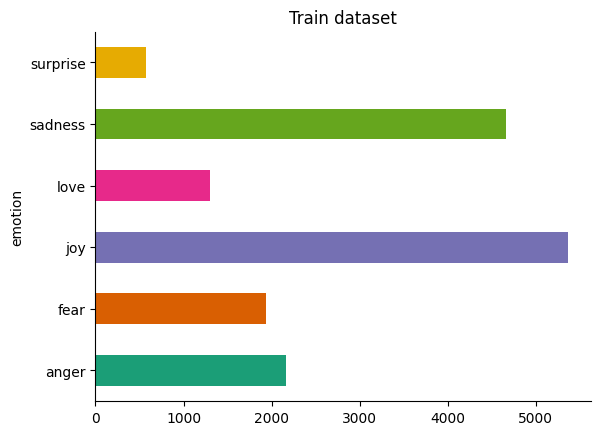

In [22]:
df_train.groupby('emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Train dataset')

In [23]:
df_test = pd.read_csv('./test.txt', delimiter=';', header=None, names=['text','emotion'])
df_test

,text,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


Text(0.5, 1.0, 'Test dataset')

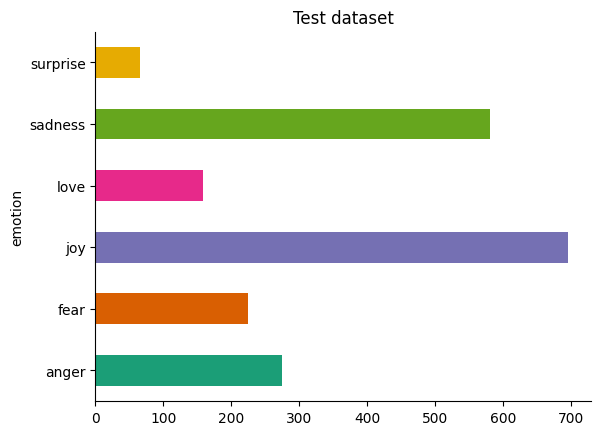

In [24]:
df_test.groupby('emotion').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.title('Test dataset')

In [25]:
df_train['emotion'].value_counts()

emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [26]:
df_test['emotion'].value_counts()

emotion
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

In [27]:
label_enc = LabelEncoder()
df_train['label'] = label_enc.fit_transform(df_train['emotion'])
df_test['label'] = label_enc.transform(df_test['emotion'])

In [28]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     16000 non-null  object
 1   emotion  16000 non-null  object
 2   label    16000 non-null  int32 
dtypes: int32(1), object(2)
memory usage: 312.6+ KB


In [29]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2000 non-null   object
 1   emotion  2000 non-null   object
 2   label    2000 non-null   int32 
dtypes: int32(1), object(2)
memory usage: 39.2+ KB


In [30]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
batch_size = 32
max_len = 128

In [31]:
class Emotion_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_len, label_encoder):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.df.loc[index, 'text'])
        emotion = self.df.loc[index, 'emotion']

        emotion_id = self.label_encoder.transform([emotion])[0]

        encoded = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoded['input_ids'].flatten(),
            'attention_mask': encoded['attention_mask'].flatten(),
            'emotion': torch.tensor(emotion_id, dtype = torch.long)
        }

In [32]:
train_dataset = Emotion_Dataset(df_train, tokenizer, max_len, label_encoder=label_enc)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

test_dataset = Emotion_Dataset(df_test, tokenizer, max_len, label_encoder=label_enc)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [33]:
class Bert_Model(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(Bert_Model, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(self.bert.config.hidden_size, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs.last_hidden_state[:, 0, :])
        output1 = self.fc(sequence_output)
        output2 = self.dropout2(output1)
        logits = self.fc2(output2)
        return logits

In [34]:
bert_model = 'bert-base-uncased'
num_classes = df_train["emotion"].nunique()
model = Bert_Model(bert_model, num_classes)
criterion = nn.CrossEntropyLoss()
lr = 2e-5
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

Bert_Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [35]:
def train(model, train_loader, criterion, optimizer, epochs, device):
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['emotion'].to(device)

            optimizer.zero_grad()
            # prediction
            outputs = model(input_ids, attention_mask)

            # loss function
            loss = criterion(outputs, labels)

            # backpropagation and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # accuracy
            logits = outputs.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            total_samples += labels.size(0)
            correct_predictions += np.sum(np.argmax(logits, axis=1) == label_ids)

        train_losses.append(running_loss / len(train_loader))
        accuracy = correct_predictions / total_samples
        train_accuracies.append(accuracy)

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy * 100:.2f}%')

    return train_losses, train_accuracies

In [36]:
epochs = 10
train_losses, train_accuracies = train(model, train_loader, criterion, optimizer, epochs, device)

Epoch 1/10, Train Loss: 0.5544, Accuracy: 80.11%
Epoch 2/10, Train Loss: 0.1451, Accuracy: 94.01%
Epoch 3/10, Train Loss: 0.1059, Accuracy: 95.11%
Epoch 4/10, Train Loss: 0.0860, Accuracy: 95.86%
Epoch 5/10, Train Loss: 0.0737, Accuracy: 96.57%
Epoch 6/10, Train Loss: 0.0631, Accuracy: 96.94%
Epoch 7/10, Train Loss: 0.0576, Accuracy: 97.54%
Epoch 8/10, Train Loss: 0.0413, Accuracy: 98.27%
Epoch 9/10, Train Loss: 0.0401, Accuracy: 98.49%
Epoch 10/10, Train Loss: 0.0291, Accuracy: 98.94%


In [38]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['emotion'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask)

            # loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # accuracy 
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    test_losses = test_loss / len(data_loader)
    test_accuracy = correct_predictions / total_samples

    print(f'Test Loss: {test_losses:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')

    return test_losses, test_accuracy

In [39]:
test_losses, test_accuracy = evaluate(model, test_loader, criterion, device)

Test Loss: 0.2588, Test Accuracy: 92.55%


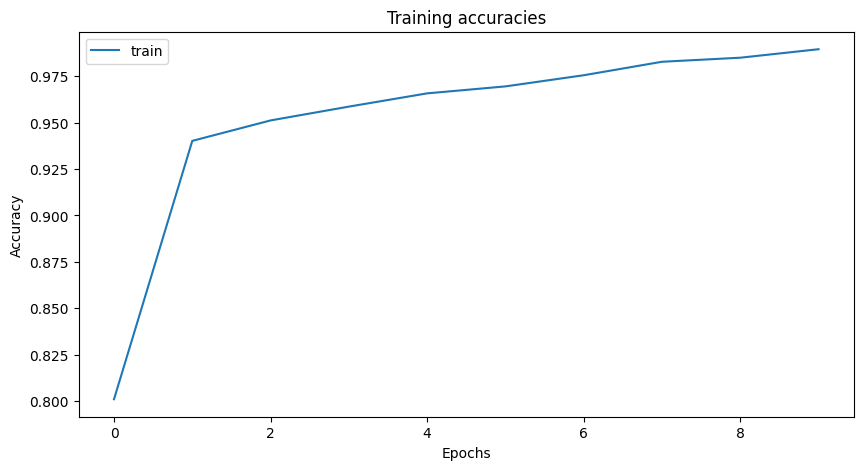

In [40]:
# Accuracy's plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Training accuracies")
plt.plot(train_accuracies, label="train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

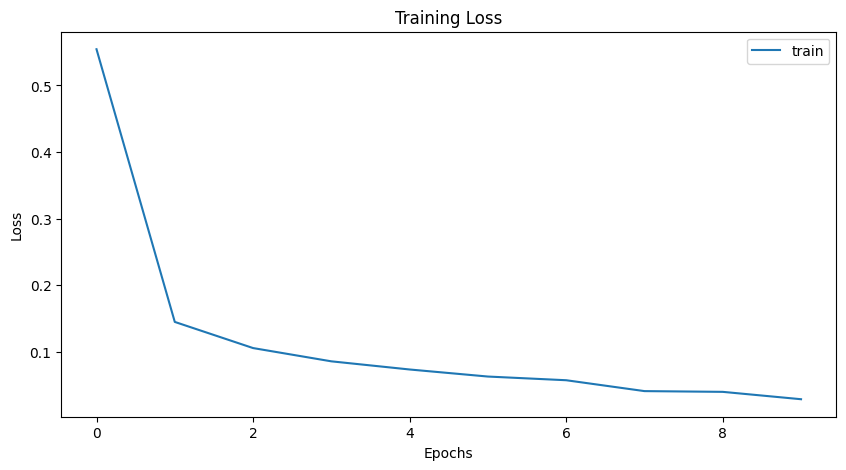

In [41]:
# Loss function's plot
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_losses, label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()